In [1]:
import sys
sys.path.insert(0, '../Lib')
from homeworkLib import EEGGraph
import pickle
import bct
import numpy as np
import connectivipy as cp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import re
bct.make_motif34lib()

motif34lib already exists


In [2]:
with open("../Pickle/all_channel_graphs.pickle", "rb") as f:
    F = pickle.load(f)
with open("../Pickle/subset_channel_graphs.pickle", "rb") as f:
    F_red = pickle.load(f)

F
F_red

([<networkx.classes.digraph.DiGraph at 0x280ec97ae48>,
 ['DTF (eyes-open, n/w density 20%, freq 1 Hz)',
  'PDC (eyes-open, n/w density 20%, freq 1 Hz)',
  'DTF (eyes-closed, n/w density 20%, freq 1 Hz)',
  'PDC (eyes-closed, n/w density 20%, freq 1 Hz)'])

In [3]:
#doing analysis using the dtf graphs
motif_graph_opened = F[0][0]
motif_graph_closed = F[0][2]
motif_graph_opened_red = F_red[0][0]
motif_graph_closed_red = F_red[0][2]

In [4]:
#checking if networks are directed or not
motif_graph_opened.is_directed()
motif_graph_closed.is_directed()

True

In [5]:
#converting graph to numpy matrix
A_Opened = nx.to_numpy_matrix( motif_graph_opened)
A_Closed = nx.to_numpy_matrix( motif_graph_closed)
A_Opened_red = nx.to_numpy_matrix( motif_graph_opened_red)
A_Closed_red = nx.to_numpy_matrix( motif_graph_closed_red)

In [6]:
#Getting the frequencies of each motif category for each network
#First getting the frequency values for the size = 3; tot motif = 13
Freq_Opened_3_, f_values_opened_3 = bct.motif3struct_bin(A_Opened)
Freq_Opened_3 = {str(i+1): Freq_Opened_3_[i] for i in range(len(Freq_Opened_3_))}
Freq_Closed_3_, f_values_closed_3 = bct.motif3struct_bin(A_Closed)
Freq_Closed_3 = {str(i+1):Freq_Closed_3_[i] for i in range(len(Freq_Closed_3_))}

Freq_Opened_3_red_, f_values_opened_3_red = bct.motif3struct_bin(A_Opened_red)
Freq_Opened_3_red = {str(i+1): Freq_Opened_3_red_[i] for i in range(len(Freq_Opened_3_red_))}
Freq_Closed_3_red_, f_values_closed_3_red = bct.motif3struct_bin(A_Closed_red)
Freq_Closed_3_red = {str(i+1):Freq_Closed_3_red_[i] for i in range(len(Freq_Closed_3_red_))}

#second getting the frequency values for the size = 4, tot motifs = 199
Freq_Opened_4_,f_values_opened_4 = bct.motif4struct_bin(A_Opened)
Freq_Opened_4 = {str(i+1): Freq_Opened_4_[i] for i in range(len(Freq_Opened_4_))}
Freq_Closed_4_, f_values_closed_4 = bct.motif4struct_bin(A_Closed)
Freq_Closed_4 = {str(i+1): Freq_Closed_4_[i] for i in range(len(Freq_Closed_4_))}

Freq_Opened_4_red_,f_values_opened_4_red = bct.motif4struct_bin(A_Opened_red)
Freq_Opened_4_red = {str(i+1): Freq_Opened_4_red_[i] for i in range(len(Freq_Opened_4_red_))}
Freq_Closed_4_red_, f_values_closed_4_red = bct.motif4struct_bin(A_Closed_red)
Freq_Closed_4_red = {str(i+1): Freq_Closed_4_red_[i] for i in range(len(Freq_Closed_4_red_))}

In [7]:
#get the motif frequencies of size 3 of a directed graph
def get_motif_frequencies_3(G):
    A = nx.to_numpy_matrix( G)
    F, f = bct.motif3funct_bin(A)
    return( {str(i+1) : F[i] for i in range(len(F))})
#get the motifs frequencies of size 4 of a directed graph   
def get_motif_frequencies_4(G):
    A = nx.to_numpy_matrix( G)
    F, f = bct.motif4funct_bin(A)
    return( {str(i+1) : F[i] for i in range(len(F))})    

In [8]:
def Generate_random_F(A):
    #creating the resulting matrix
    G = np.zeros(A.shape)
    #preparing the columns
    c = np.arange(len(A))
    Col_Sum= list(np.asarray(np.sum(A, axis = 0))[0,:])
    #preparing the rows
    r = np.arange(len(A))
    Row_Sum = list(np.asarray(np.sum(A, axis = 1))[:,0])
    #preparing the exit conditions
    iterations = 0
    #print(len(Row_Sum),len(Col_Sum))
    while (sum(Col_Sum) + sum(Row_Sum) !=0):
        #getting probability values from Rows&cols sums
        p_r = [e/sum(Row_Sum) for e in Row_Sum]
        p_c = [e/sum(Col_Sum) for e in Col_Sum]
        #randomly generating number based on previous prob
        i = int(np.random.choice(r, size = 1, replace = False, p = p_r))
        j = int(np.random.choice(c, size = 1, replace = False, p = p_c))
        #if matrix empty
        if (G[i,j] == 0) or (j == i):
            G[i,j] = 1
            #remove 1 to decrese the importance of particular position
            Row_Sum[i]= Row_Sum[i]-1
            Col_Sum[j] = Col_Sum[j]- 1
        else:
            iterations = iterations + 1
        if iterations > 100:
            break
    return(nx.from_numpy_matrix(G, create_using=nx.DiGraph()))

In [9]:
def get_significance(G,freq,conf=3, max_iter=100):   
    A = nx.adjacency_matrix(G).todense()
    sign = dict()
    anti_motifs = dict()
    for i in tqdm(range(max_iter)):
        if conf == 3:
            random_net = get_motif_frequencies_3(Generate_random_F(A))
        else:
            random_net = get_motif_frequencies_4(Generate_random_F(A))
        for category in freq.keys():
            if sign.get(category) == None:
                sign[category]=[freq[category]< random_net[category]]
            else: 
                sign[category].append(freq[category]< random_net[category])
            if anti_motifs.get(category) == None:
                anti_motifs[category]=[(random_net[category]- freq[category])>0.5*random_net[category]]      
            else: 
                anti_motifs[category].append((random_net[category]- freq[category])>0.5 * random_net[category])
    return(sign,anti_motifs)


In [10]:
# get the overrepresented categories
def get_over_representations(sign, prob =0.95):
    return({cat: sum(sign[cat])/100 for cat in sign.keys() if sum(sign[cat])/100 <1-prob})
# get the antimotifs
def get_anti_motifs(sign, prob = 0.95):
    return({cat: sum(sign[cat])/100 for cat in sign.keys() if sum(sign[cat])/100 >prob})

In [11]:
# Create a table with the results
def get_results(frequencies, over_representations, antimotifs):
    results = pd.DataFrame()
    results["Categories"]= list(frequencies.keys())
    results.set_index('Categories')
    results["Frequencies"] = results['Categories'].map(frequencies)
    results["Over Represented"] = results['Categories'].map(over_representations)
    results["Anti Motifs"] = results['Categories'].map(antimotifs)
    return (results)
# saves the results
def save_results (res, title):
    df = pd.DataFrame.from_dict(res)
    df.to_csv("results_struct/"+ title+".csv", index=False)    

In [12]:
sign_opened_3, anti_motifs_opened_3 = get_significance(motif_graph_opened, Freq_Opened_3,3,100)
sign_closed_3, anti_motifs_closed_3 = get_significance(motif_graph_closed, Freq_Closed_3,3,100)
sign_opened_3_red, anti_motifs_opened_3_red = get_significance(motif_graph_opened_red, Freq_Opened_3_red,3,100)
sign_closed_3_red, anti_motifs_closed_3_red = get_significance(motif_graph_closed_red, Freq_Closed_3_red,3,100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.85it/s]


In [13]:
# Full graph
over_rep_3_opened = get_over_representations(sign_opened_3)
antimotifs_3_opened = get_anti_motifs(anti_motifs_opened_3)
over_rep_3_closed = get_over_representations(sign_closed_3)
antimotifs_3_closed = get_over_representations(anti_motifs_closed_3)
# Reduced graph
over_rep_3_opened_red = get_over_representations(sign_opened_3_red)
antimotifs_3_opened_red = get_anti_motifs(anti_motifs_opened_3_red)
over_rep_3_closed_red = get_over_representations(sign_closed_3_red)
antimotifs_3_closed_red = get_over_representations(anti_motifs_closed_3_red)

In [14]:
print("Results of the Open State Full Graph")
res_eo_3= get_results(Freq_Opened_3, over_rep_3_opened, antimotifs_3_opened)
res_eo_3

Results of the Open State Full Graph


,Categories,Frequencies,Over Represented,Anti Motifs
0,1,7537.0,0.00,NaN
1,2,589.0,NaN,1.0
2,3,828.0,NaN,NaN
3,4,1965.0,0.00,NaN
4,5,1892.0,0.00,NaN
5,6,51.0,NaN,1.0
6,7,37.0,NaN,1.0
7,8,1680.0,0.00,NaN
8,9,256.0,NaN,NaN
9,10,220.0,NaN,NaN


In [15]:
print("Results of the Open State reduced")
res_eo_3_red= get_results(Freq_Opened_3_red, over_rep_3_opened_red, antimotifs_3_opened_red)
res_eo_3_red

Results of the Open State reduced


,Categories,Frequencies,Over Represented,Anti Motifs
0,1,105.0,NaN,NaN
1,2,29.0,NaN,1.00
2,3,50.0,NaN,1.00
3,4,34.0,NaN,NaN
4,5,35.0,NaN,0.98
5,6,4.0,NaN,1.00
6,7,0.0,NaN,1.00
7,8,20.0,NaN,NaN
8,9,9.0,NaN,NaN
9,10,1.0,NaN,1.00


In [16]:
#the non empty collumns are overep or anti motifs
print("Results of the Closed State")
res_ec_3 = get_results(Freq_Closed_3, over_rep_3_closed, antimotifs_3_closed)
res_ec_3

Results of the Closed State


,Categories,Frequencies,Over Represented,Anti Motifs
0,1,7680.0,0.00,0.0
1,2,491.0,NaN,NaN
2,3,882.0,NaN,0.0
3,4,1496.0,0.00,0.0
4,5,2025.0,0.00,0.0
5,6,65.0,NaN,NaN
6,7,9.0,NaN,NaN
7,8,1746.0,0.00,0.0
8,9,233.0,0.00,0.0
9,10,125.0,0.04,0.0


In [17]:
#the non empty collumns are overep or anti motifs
print("Results of the Closed State")
res_ec_3_red=get_results(Freq_Closed_3_red, over_rep_3_closed_red, antimotifs_3_closed_red)
res_ec_3_red

Results of the Closed State


,Categories,Frequencies,Over Represented,Anti Motifs
0,1,75.0,NaN,0.04
1,2,28.0,NaN,NaN
2,3,40.0,NaN,NaN
3,4,20.0,NaN,NaN
4,5,38.0,NaN,NaN
5,6,6.0,NaN,NaN
6,7,3.0,NaN,NaN
7,8,13.0,NaN,NaN
8,9,17.0,NaN,NaN
9,10,7.0,NaN,NaN


In [18]:
#empty cells mean that no overrepresentation or antimotifs were found
save_results(res_eo_3, "31_motifs_eo_3")
save_results(res_eo_3_red, "31_motifs_eo_3_red")
save_results(res_ec_3, "31_motifs_ec_3")
save_results(res_eo_3_red, "31_motifs_ec_3_red")

#### 3.2 For the motif with pattern A → B ← C , create a topographical representation of the networks considering only the connections involved in this configuration.

In [19]:
#locations for the full graph
locations = pd.read_csv("../../Data/channel_locations.txt", sep = "\s+") 
locations["label"] = locations["label"].apply(lambda x:re.sub('[^\w]',"",x))
locations = locations.set_index('label')

#locations for the reduced graph 
locations_red = pd.read_csv("../../Data/channel_locations.txt", sep = "\s+")
locations_red["label"] = locations_red["label"].apply(lambda x:re.sub('[^\w]',"",x))
reduced = ["Fp1","Fp2","F7","F3","Fz","F4","F8","T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1","O2"]
loc = (locations_red["label"] == reduced[0])
for i in range(1,len(reduced)):
    loc = loc | (locations_red["label"] == reduced[i])
locations_red = locations_red[loc]
locations_red = locations_red.set_index('label')

In [20]:
def draw_single_motifs(G, cat, freq, locations, node_size = 1000):
    nodes = np.arange(len(locations))
    labels = dict(zip(nodes, list(locations['#'].keys())))
    loc = dict()
    for node in nodes:
        loc[node] = (locations.loc[labels[node]][1],locations.loc[labels[node]][2])
    t=[]
    for i in range(len(list(freq[cat-1]))):
        if (freq[cat-1][i] != 0):
            t.append(i)
    fin_net = G.subgraph(t)
    edges= fin_net.edges
    nod= G.nodes
    res = nx.DiGraph(edges)
    res.add_nodes_from(nod)
    nx.draw(res, pos = loc, node_size=node_size,labels=labels, with_labels=True)
    plt.show()

Result for the open state full graph


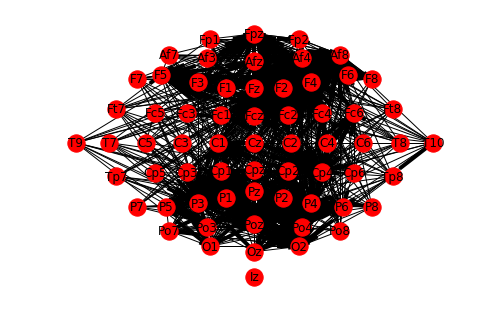

In [21]:
print("Result for the open state full graph")
draw_single_motifs(motif_graph_opened, 4, f_values_opened_3, locations,node_size=300)

Result for the open state reduced graph


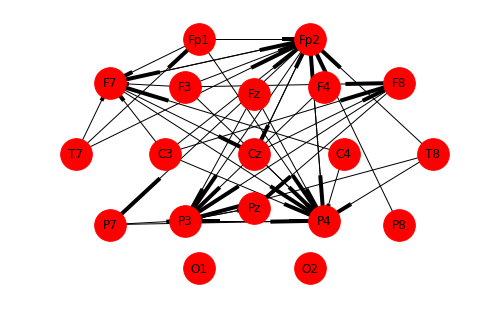

In [22]:
print("Result for the open state reduced graph")
draw_single_motifs(motif_graph_opened_red, 4, f_values_opened_3_red, locations_red)

Result for the closed state full graph


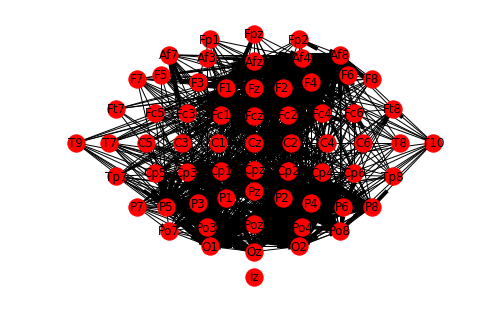

In [23]:
print("Result for the closed state full graph")
draw_single_motifs(motif_graph_closed, 4, f_values_closed_3, locations, node_size = 300)

Result for the closed state full graph


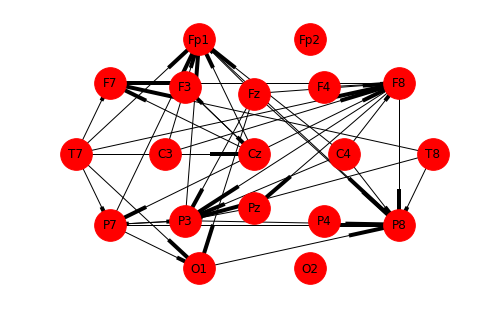

In [24]:
print("Result for the closed state full graph")
draw_single_motifs(motif_graph_closed_red, 4, f_values_closed_3_red, locations_red)

###  (class ‘C’) Choose a channel selected in parieto-occipital scalp region and determine the motifs which involve it.

In [25]:
def get_category_motifs(freq, cat):
    motifs_inv = []
    for i in range(len(freq)):
            if (freq[i][12] != 0):
                motifs_inv.append(i+1)

    print("Categories of motif involved in area ", str(cat)," : ", motifs_inv)

In [26]:
print('Opened state Full Graph (node PZ)')
get_category_motifs(f_values_opened_3, 51)

Opened state Full Graph (node PZ)
Categories of motif involved in area  51  :  [1, 2, 3, 4, 5, 6, 7, 8, 10, 11]


In [27]:
print('Closed state Full Graph (node PZ)')
get_category_motifs(f_values_closed_3, 51)

Closed state Full Graph (node PZ)
Categories of motif involved in area  51  :  [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]


In [28]:
print('Opened state reduced Graph (node PZ)')
get_category_motifs(f_values_opened_3_red, 14)

Opened state reduced Graph (node PZ)
Categories of motif involved in area  14  :  [1, 2, 3, 4, 5, 8]


In [29]:
print('Closed state reduced Graph (node PZ)')

get_category_motifs(f_values_closed_3_red, 14)

Closed state reduced Graph (node PZ)
Categories of motif involved in area  14  :  [1, 2, 3, 4, 5, 6, 8, 9, 10, 12]


### 3.4 (class ‘E’) Perform the same analysis described in task 3.1 considering 4-node motifs.

In [30]:
sign_opened_4,anti_motifs_opened_4 = get_significance(motif_graph_opened,Freq_Opened_4,4,100)
sign_closed_4,anti_motifs_closed_4 = get_significance(motif_graph_closed,Freq_Closed_4,4,100)
sign_opened_4_red, anti_motifs_opened_4_red = get_significance(motif_graph_opened_red, Freq_Opened_4_red,4,100)
sign_closed_4_red, anti_motifs_closed_4_red = get_significance(motif_graph_closed_red, Freq_Closed_4_red,4,100)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.02it/s]


In [33]:
over_rep_4_opened = get_over_representations(sign_opened_4)
antimotifs_4_opened = get_anti_motifs(anti_motifs_opened_4)
over_rep_4_closed = get_over_representations(sign_closed_4)
antimotifs_4_closed = get_over_representations(anti_motifs_closed_4)

over_rep_4_opened_red = get_over_representations(sign_opened_4_red)                                                          
antimotifs_4_opened_red = get_anti_motifs(anti_motifs_opened_4_red)
over_rep_4_closed_red = get_over_representations(sign_closed_4_red)
antimotifs_4_closed_red = get_over_representations(anti_motifs_closed_4_red) 

#### resuts for the open state

In [35]:
print("Results of the Open State for node size 4")
result_opened_4= get_results(Freq_Opened_4, over_rep_4_opened, antimotifs_4_opened)
result_opened_4_freq = result_opened_4[result_opened_4.Frequencies != 0]
result_opened_4_freq

Results of the Open State for node size 4


,Categories,Frequencies,Over Represented,Anti Motifs
1,2,11300.0,NaN,NaN
2,3,1668.0,NaN,1.00
3,4,1646.0,NaN,1.00
4,5,6445.0,NaN,NaN
5,6,163.0,NaN,1.00
6,7,289.0,NaN,1.00
7,8,1037.0,NaN,1.00
8,9,3765.0,NaN,NaN
9,10,166.0,NaN,1.00
10,11,455.0,NaN,1.00


In [36]:
result_opened_4_or = result_opened_4.dropna(subset=['Over Represented'])
result_opened_4_or

,Categories,Frequencies,Over Represented,Anti Motifs
0,1,0.0,0.0,NaN


In [37]:
result_opened_4_a = result_opened_4.dropna(subset=['Anti Motifs'])
result_opened_4_a

,Categories,Frequencies,Over Represented,Anti Motifs
2,3,1668.0,NaN,1.00
3,4,1646.0,NaN,1.00
5,6,163.0,NaN,1.00
6,7,289.0,NaN,1.00
7,8,1037.0,NaN,1.00
9,10,166.0,NaN,1.00
10,11,455.0,NaN,1.00
11,12,1807.0,NaN,1.00
12,13,511.0,NaN,1.00
13,14,78.0,NaN,1.00


#### result for the open state reduced

In [38]:
print("Results of the Open State for node size 4 reduced")
result_opened_4_red= get_results(Freq_Opened_4_red, over_rep_4_opened_red, antimotifs_4_opened_red)
#frequencies
result_opened_4_freq_red = result_opened_4_red[result_opened_4_red.Frequencies != 0]
result_opened_4_freq_red

Results of the Open State for node size 4 reduced


,Categories,Frequencies,Over Represented,Anti Motifs
1,2,152.0,NaN,1.00
2,3,49.0,NaN,1.00
3,4,49.0,NaN,1.00
4,5,100.0,NaN,1.00
5,6,9.0,NaN,1.00
6,7,6.0,NaN,1.00
7,8,26.0,NaN,1.00
8,9,51.0,NaN,1.00
9,10,18.0,NaN,1.00
10,11,27.0,NaN,1.00


In [39]:
#overrepresented
result_opened_4_or_red = result_opened_4_red.dropna(subset=['Over Represented'])
result_opened_4_or_red

,Categories,Frequencies,Over Represented,Anti Motifs
0,1,0.0,0.0,NaN


In [40]:
#antimotifs
result_opened_4_a_red = result_opened_4_red.dropna(subset=['Anti Motifs'])
result_opened_4_a_red

,Categories,Frequencies,Over Represented,Anti Motifs
1,2,152.0,NaN,1.0
2,3,49.0,NaN,1.0
3,4,49.0,NaN,1.0
4,5,100.0,NaN,1.0
5,6,9.0,NaN,1.0
6,7,6.0,NaN,1.0
7,8,26.0,NaN,1.0
8,9,51.0,NaN,1.0
9,10,18.0,NaN,1.0
10,11,27.0,NaN,1.0


In [41]:
#antimotifs
result_opened_4_a_red = result_opened_4_red.dropna(subset=['Anti Motifs'])
result_opened_4_a_red

,Categories,Frequencies,Over Represented,Anti Motifs
1,2,152.0,NaN,1.0
2,3,49.0,NaN,1.0
3,4,49.0,NaN,1.0
4,5,100.0,NaN,1.0
5,6,9.0,NaN,1.0
6,7,6.0,NaN,1.0
7,8,26.0,NaN,1.0
8,9,51.0,NaN,1.0
9,10,18.0,NaN,1.0
10,11,27.0,NaN,1.0


#### result for the closed state

In [42]:
print("Results of the Closed State for node size 4")
result_closed_4= get_results(Freq_Closed_4, over_rep_4_closed, antimotifs_4_closed)

Results of the Closed State for node size 4


In [43]:
result_closed_4_freq = result_closed_4[result_closed_4.Frequencies != 0]
result_closed_4_freq

,Categories,Frequencies,Over Represented,Anti Motifs
1,2,15959.0,NaN,0.0
2,3,2083.0,NaN,NaN
3,4,2072.0,NaN,NaN
4,5,12792.0,NaN,0.0
5,6,227.0,NaN,NaN
6,7,543.0,NaN,NaN
7,8,1141.0,NaN,NaN
8,9,7082.0,NaN,NaN
9,10,401.0,NaN,NaN
10,11,524.0,NaN,NaN


In [44]:
result_closed_4_or = result_closed_4.dropna(subset=['Over Represented'])
result_closed_4_or

,Categories,Frequencies,Over Represented,Anti Motifs
0,1,0.0,0.0,0.0


In [45]:
result_closed_4_a = result_closed_4.dropna(subset=['Anti Motifs'])
result_closed_4_a

,Categories,Frequencies,Over Represented,Anti Motifs
0,1,0.0,0.0,0.00
1,2,15959.0,NaN,0.00
4,5,12792.0,NaN,0.00
67,68,1016.0,NaN,0.05
126,127,222.0,NaN,0.01


result for the closed state reduced

In [46]:
print("Results of the Closed State for node size 4 (reduced)")
result_closed_4_red= get_results(Freq_Closed_4_red, over_rep_4_closed_red, antimotifs_4_closed_red)

Results of the Closed State for node size 4 (reduced)


In [47]:
#frequencies
result_closed_4_freq_red = result_closed_4_red[result_closed_4_red.Frequencies != 0]
result_closed_4_freq_red

,Categories,Frequencies,Over Represented,Anti Motifs
1,2,74.0,NaN,NaN
2,3,23.0,NaN,NaN
3,4,12.0,NaN,NaN
4,5,65.0,NaN,NaN
5,6,3.0,NaN,NaN
6,7,9.0,NaN,NaN
7,8,11.0,NaN,NaN
8,9,31.0,NaN,NaN
10,11,9.0,NaN,NaN
11,12,19.0,NaN,NaN


In [48]:
#overrepresentations
result_closed_4_or_red = result_closed_4_red.dropna(subset=['Over Represented'])
result_closed_4_or_red

,Categories,Frequencies,Over Represented,Anti Motifs
0,1,0.0,0.0,0.0


In [49]:
#antimotifs
result_closed_4_a_red = result_closed_4_red.dropna(subset=['Anti Motifs'])
result_closed_4_a_red

,Categories,Frequencies,Over Represented,Anti Motifs
0,1,0.0,0.0,0.0


In [50]:
save_results(result_opened_4, "34_motifs_eo_4_full")
save_results(result_opened_4_freq, "34_motifs_eo_4_freq")
save_results(result_opened_4_or, "34_motifs_eo_4_overrepresentation")
save_results(result_opened_4_a, "34_motifs_eo_4_antimotifs")

save_results(result_closed_4, "34_motifs_ec_4_full")
save_results(result_closed_4_freq, "34_motifs_ec_4_frequencies")
save_results(result_closed_4_or, "34_motifs_ec_4_overrep")
save_results(result_closed_4_a, "34_motifs_ec_4_antimotifs")

save_results(result_opened_4_red, "34_motifs_eo_4_full")
save_results(result_opened_4_freq_red, "34_motifs_eo_4_freq")
save_results(result_opened_4_or_red ,"34_motifs_eo_4_overrep")
save_results(result_opened_4_a_red, "34_motifs_eo_4_antimotifs")

save_results(result_closed_4_red, "34_motifs_ec_4_full")
save_results(result_closed_4_freq_red, "34_motifs_ec_4_frequencies")
save_results(result_closed_4_or_red, "34_motifs_ec_4_overrepresentation")
save_results(result_closed_4_a_red, "34_motifs_ec_4_antimotifs")